In [1]:
#load these before doing anything else
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Title: Clinical Determinants of Heart Disease ##

### Introduction:
We are using the Heart Disease Dataset from Kaggle (link: https://www.kaggle.com/datasets/ineubytes/heart-disease-dataset)
The data set contains 14 columns, which include information of the patients’ age, sex, chest pain, cholesterol levels, and other clinical factors. The last column, target, indicated by values 0, and 1, represents whether the patient has heart defects (0 = does not have heart disease; 1 = have heart disease). The dataset seems to already be in a tidy format.

Research question: We are aiming to predict whether an individual has heart disease (ie. the target value) using possibly 4 or less predictors including, age, serum cholesterol in mg/dl(chol), maximum heart rate achieved(thalach), resting blood pressure (in mm Hg on admission to the hospital)(trestbps). 

We chose these four predicators because they seem clinically related to the risk of heart disease. Clinical data identifies cholesterol at and above 240 mg/dl to be high. Systolic blood pressure over 140 mmHg and/or diastolic blood pressure over 90 mmHg are considered high blood pressure. It is considered critical if one’s maximum heart rate exceed their age subtracted by 200. These factors have all be proven to increase the risk of heart disease in patients. We are analyzing our data with the help of these clinical standards. 


## Preliminary exploratory data analysis ##

Reading in our dataset and selecting for the columns we are going to use

In [3]:
set.seed(123)
heart_data<-read_csv("https://raw.githubusercontent.com/jewelw11/dsci-100-project/main/heart%20(4).csv")

heart_data_1<- heart_data|>
select(age, trestbps, chol, thalach, target) |>
mutate(target=as_factor(target))



Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Data Wrangling ###
The data set we are working with is considered tidy as it fullfills the three rules of a tidy data set. We splitted the data set into 75% training set and 25% testing sets. The below table shows the training set after we have selected the target column (what we are trying to predict) and coloumns we are considering to use as our predictos. 

In [4]:
heart_split <- initial_split(heart_data_1, prop = 0.75, strata = target)
heart_training<-training(heart_split)
heart_testing<- testing(heart_split)
heart_training

age,trestbps,chol,thalach,target
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
53,140,203,155,0
70,145,174,125,0
61,148,203,161,0
⋮,⋮,⋮,⋮,⋮
47,112,204,143,1
59,140,221,164,1
50,110,254,159,1


### Exploratory Data Analyses ### 

#### summary tables ####
We produced a table of the mean values of all columns. We then separated the dataset into two groups, one will only individuals with heart defects and the other one without. We took the mean of each column again and were able to compare mean values between the two groups.

In [35]:
mean_data <- heart_data|>
    map_df(mean, na.rm=TRUE)
mean_data 

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.43415,0.6956098,0.942439,131.6117,246,0.1492683,0.5297561,149.1141,0.3365854,1.071512,1.385366,0.7541463,2.323902,0.5131707


In [36]:
mean_has_heart_disease <- heart_data|>
filter(target == 1)|> 
map_df(mean, na.rm = TRUE)


mean_no_heart_disease <- heart_data|>
filter(target == 0)|> 
map_df(mean, na.rm = TRUE)


mean_has_heart_disease
mean_no_heart_disease


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52.40875,0.5703422,1.378327,129.2452,240.9791,0.134981,0.5988593,158.5856,0.134981,0.569962,1.593156,0.3707224,2.119772,1


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
56.56914,0.8276553,0.4829659,134.1062,251.2926,0.1643287,0.4569138,139.1303,0.5490982,1.6002,1.166333,1.158317,2.539078,0


Using the Cholesterol (chol column), we output the below table to determine whether there is a higher number of individuals who have high cholesterol levels in patients who have heart disease than those who do not.

Note: 
target value: 0 = not diagnosed with heart disease, 1 = diagnosed with heart disease

determination of high cholesterol: High cholesterol is clinically diagnosed when a patient's cholesterol is equal to or over 240 mg/dl

In [37]:
high_chol <- heart_training |>
select(chol, target)|>
filter(chol >= 240)|>
group_by(target)|>
summarize(count=n())

high_chol

target,count
<fct>,<int>
0,214
1,187


Normal max heart rate is calculated using a fixed equation: 220 - age.
The below table compares the calculated (normal) max heart rate with the measured heart rate(thalach column).
We can quantify whether heart rate is critically high by comparing these two rows. If the difference between the 2 rows is a negative value then max heart rate is considered high and potentially dangerous.

In [38]:
normal_max_heart_rate <- heart_training|>
mutate(normal_thalach = 220 - age)

high_heart_rate <- normal_max_heart_rate|>
mutate(diff_thalach= normal_thalach - thalach)|>
mutate(diff_thalach_2 = ifelse(diff_thalach >= 0, "no", "yes"))
high_heart_rate

age,trestbps,chol,thalach,target,normal_thalach,diff_thalach,diff_thalach_2
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>
53,140,203,155,0,167,12,no
70,145,174,125,0,150,25,no
61,148,203,161,0,159,-2,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
47,112,204,143,1,173,30,no
59,140,221,164,1,161,-3,yes
50,110,254,159,1,170,11,no


#### Visualization for Maximum Heart Rate (thalach column) ####

The goal of the bar graph is to determine the difference in proportion of patients who have a high max heart rate within the two groups (have and does not have heart disease). We want to plot thalach against target. We editted the data in the table above to make thalach a categorical data (is or is not considered high) and used it to create this bar graph.

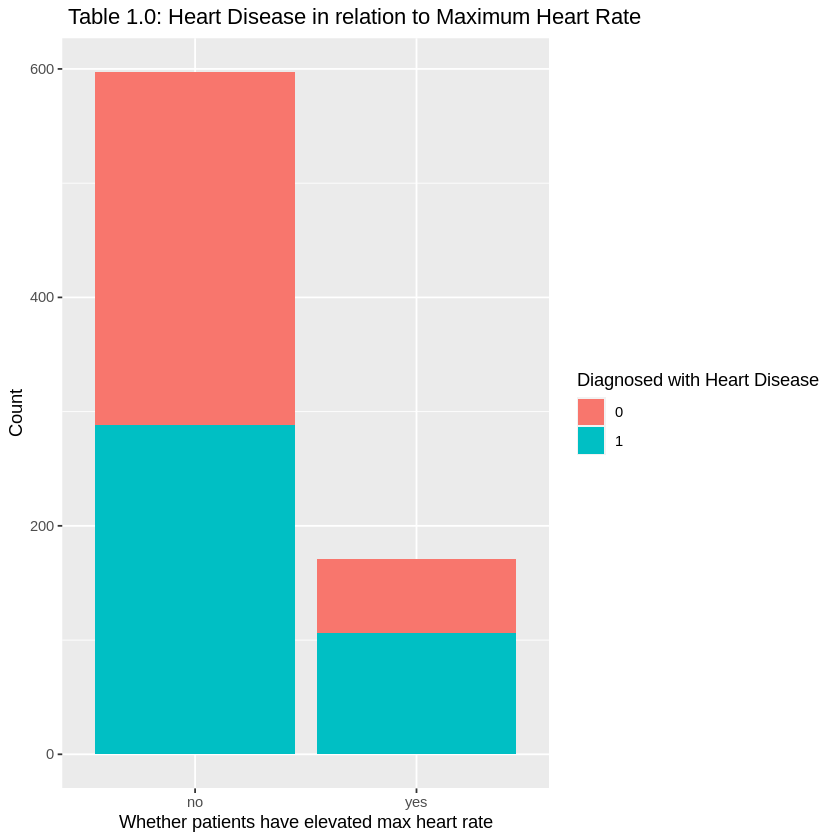

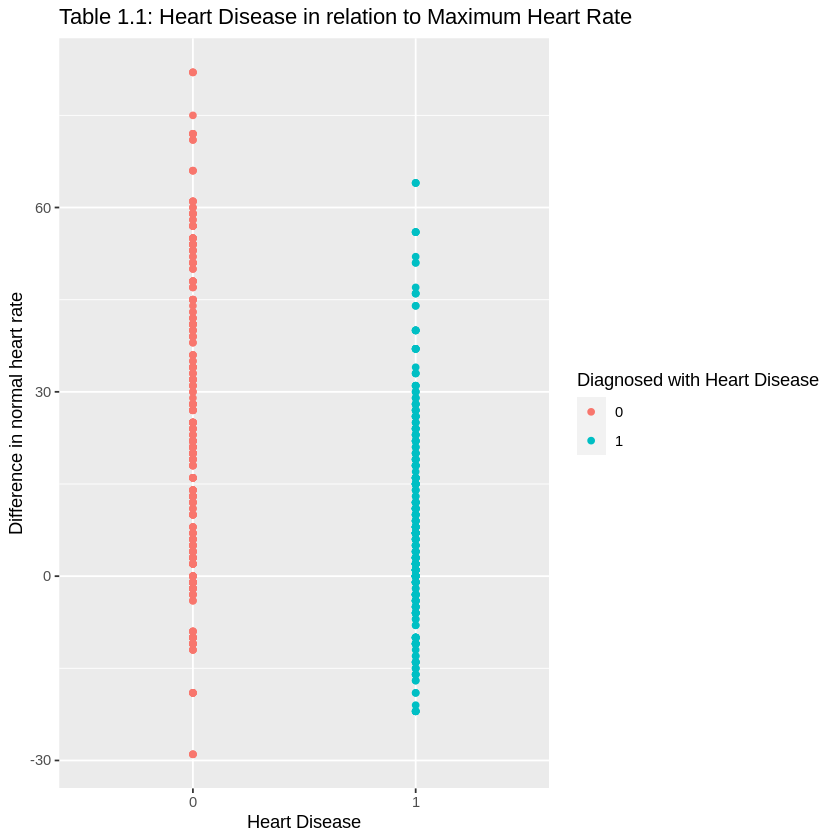

In [44]:
high_heart_plot <- high_heart_rate |>
ggplot(aes(x = diff_thalach_2, fill = target)) + 
geom_bar(stat = "count") + 
labs(x = "Whether patients have elevated max heart rate", y = "Count", fill= "Diagnosed with Heart Disease")+
ggtitle(" Table 1.0: Heart Disease in relation to Maximum Heart Rate") 
high_heart_plot

#second plot (same data):
plot<- high_heart_rate|>
ggplot(aes(x= target, y= diff_thalach, color= target))+
geom_point()+
labs(x= "Heart Disease", y= "Difference in normal heart rate", colour= "Diagnosed with Heart Disease" )+
ggtitle("Table 1.1: Heart Disease in relation to Maximum Heart Rate")
plot


Both graphs show that patients with a negative difference between their hypothesized "normal" max heart rate and their actual recorded max heart rate (ie, recorded max heart rate is over the normal limit), tend to be diagnosed with heart disease (1). In the first graph in particular, a greater proportion of people with a max heart rate over the normal limit have been diagnosed with heart disease, as compared to the patients without elevated max heart rates.

#### Predicator Visualizations ####
We plotted each possible predictors against target on a boxplot to find the best predictors to use.

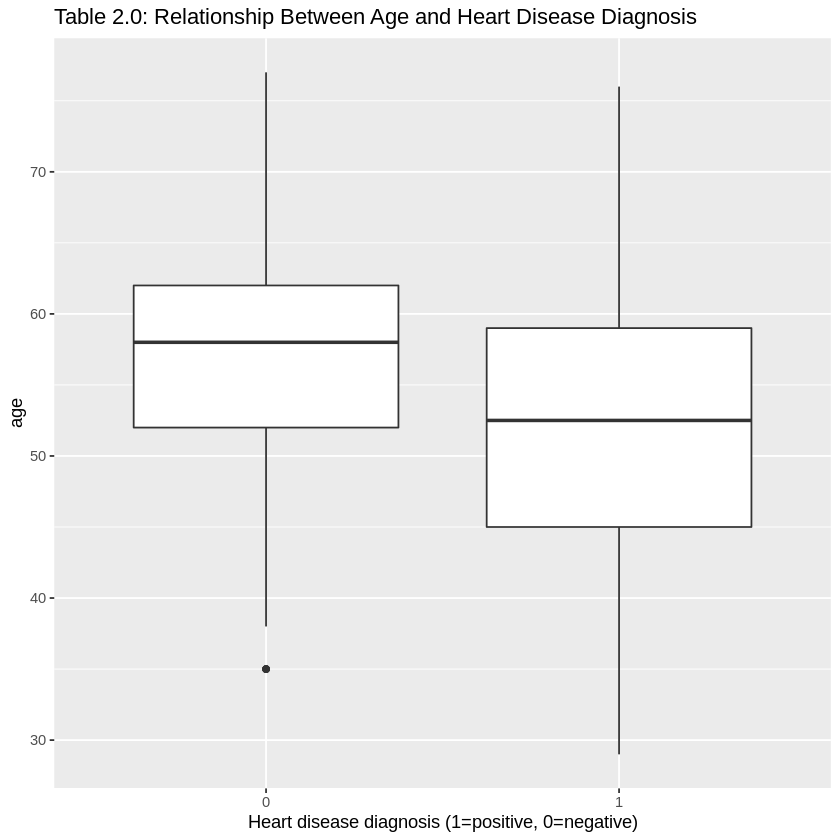

In [47]:
box_plot_age<- heart_training|>
ggplot(aes(x=age, y=target))+
geom_boxplot()+
labs(x="age", y="Heart disease diagnosis (1=positive, 0=negative)")+
ggtitle("Table 2.0: Relationship Between Age and Heart Disease Diagnosis")+
coord_flip()


box_plot_age


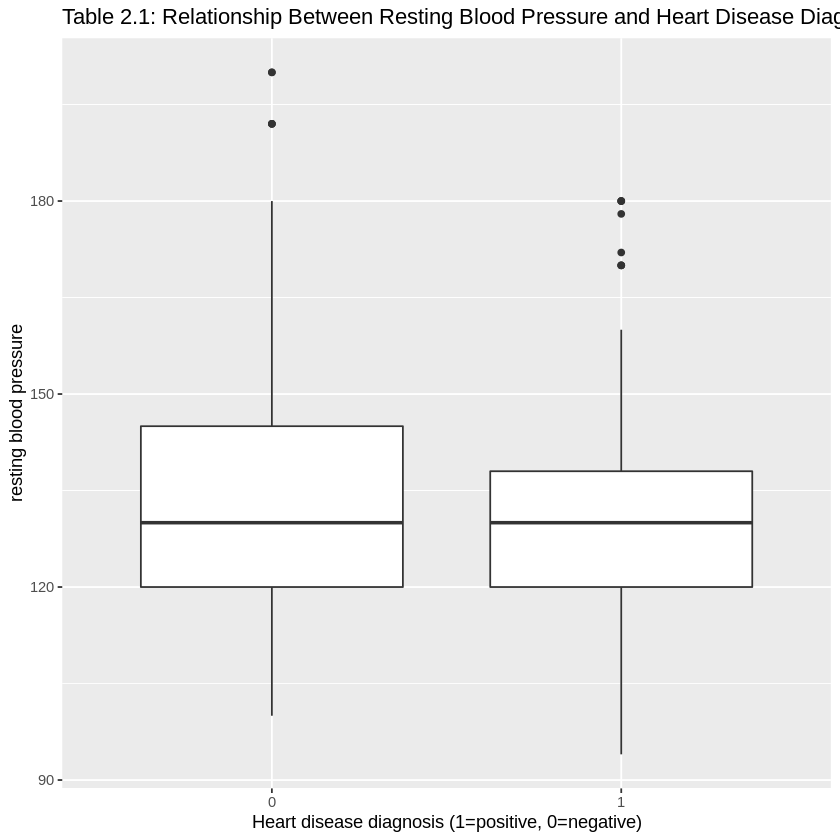

In [48]:
box_plot_bp <- heart_training|>
ggplot(aes(x=trestbps, y=target))+
geom_boxplot()+
labs(x="resting blood pressure", y="Heart disease diagnosis (1=positive, 0=negative)")+
coord_flip()+
ggtitle("Table 2.1: Relationship Between Resting Blood Pressure and Heart Disease Diagnosis")
box_plot_bp

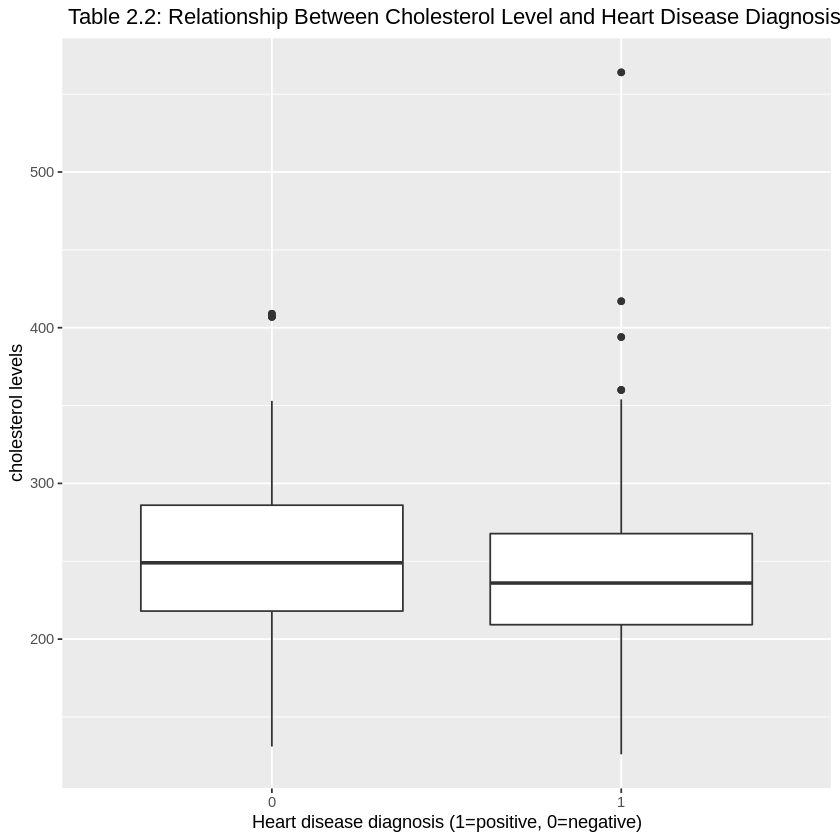

In [52]:
box_plot_chol<- heart_training|>
ggplot(aes(x=chol, y=target))+
geom_boxplot()+
labs(x="cholesterol levels", y="Heart disease diagnosis (1=positive, 0=negative)")+
coord_flip()+
ggtitle(" Table 2.2: Relationship Between Cholesterol Level and Heart Disease Diagnosis")
box_plot_chol

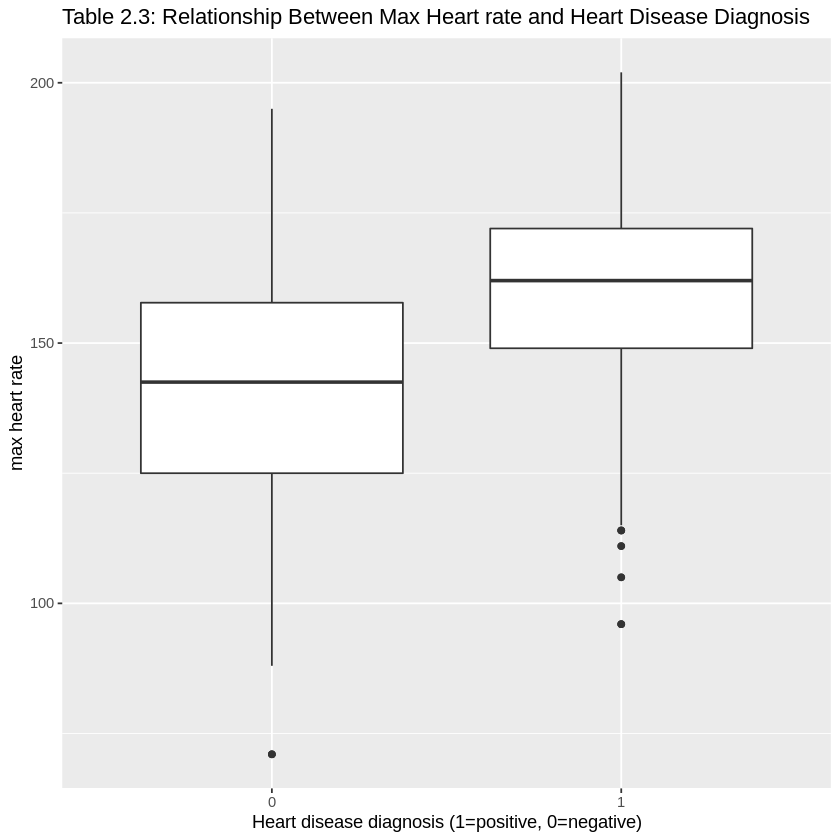

In [51]:
box_plot_max_heart<- heart_training|>
ggplot(aes(x=thalach, y=target))+
geom_boxplot()+
labs(x="max heart rate", y="Heart disease diagnosis (1=positive, 0=negative)")+
ggtitle("Table 2.3: Relationship Between Max Heart rate and Heart Disease Diagnosis")+
coord_flip()

box_plot_max_heart

After plotting four boxplots with the predictors on the x-axis and whether patients have or have not been diganosed with heart disease on the y-axis, we determined that age and max heart rate had more of a significant relationship with target, as opposed to the other two predictors (resting blood pressure and cholesterol levels). We chose those predictors because of the difference of the median as well as the range of the values. We also found that the predictors resting blood pressure and cholesterol levels had more significant outliers which is why we decided not to use those plots, as it would take away from accurate outcomes. 

#### Expected outcomes and significance #### 
We expect that factors such as increased age and heart rates would increase the chances of heart disease, meaning that you could be more susceptible to heart disease. 
This would be a very helpful way to make quick predictions of whether certain factors increase the chances of heart disease. Of course, these predictions are not professional diagnoses; however, they can still be good baseline tests for medical professionals to use on patients.
We can wonder what other factors and combinations of factors can increase the chances of heart disease. 


## Classification ##

In [ ]:
set.seed(123)
heart_training_recipe<- recipe(target~ age, thalach, data= heart_training)|>
step_center(all_predictors())|>
step_scale(all_predictors())


heart_spec<- nearest_neighbor(weight_func = "rectangular", neighbors= tune()) |>
set_engine("kknn") |>
set_mode ("classification")


heart_vfold <- vfold_cv(heart_training, v = 5, strata = target)


heart_workflow <- workflow() |>
       add_recipe(heart_training_recipe) |>
       add_model(heart_spec) |>
       fit(data = heart_training)

gridvals <- tibble(neighbors = seq(from =1, to = 100, by =5))

heart_results <- heart_workflow |>
       tune_grid(resamples = heart_vfold, grid = gridvals) |>
       collect_metrics()

heart_results

accuracy <-  heart_results |>  
filter(.metric == "accuracy")





In [ ]:
set.seed(123)

options(repr.plot.width = 10, repr.plot.height = 8)

cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
geom_point () +
geom_line () +
labs(x = "Neighbours", y = "Accuracy Estimate") +
ggtitle("Accuracy Estimate of K values") +
theme(text=element_text(size=12))+
       scale_x_continuous(breaks = seq(0, 80, by = 10))

heart_max <- accuracy |>
filter(mean == max(mean))|>
pull(neighbors)

accuracy
cross_val_plot
heart_max

In [ ]:
heart_spec<- nearest_neighbor(weight_func = "rectangular", neighbors=46) |>
set_engine("kknn")|>
set_mode("classification")



knn_fit<- workflow()|>
add_recipe(heart_training_recipe)|>
add_model(heart_spec)|>
fit(data=heart_training)


heart_test_predictions<- predict(knn_fit, heart_testing)|>
bind_cols(heart_testing)|>
metrics(truth= target, estimate=.pred_class)|>
filter(.metric=="accuracy")

heart_test_predictions


In [ ]:
Methods

We aim to perform a K-nearest neighbours classification on the heart disease dataset, using the target column as our class label, and 2 predictors. From the above boxplot analysis, we determined the two best predictors to use are age and thalach (maximum heart rate). This was decided because the two predictors seem to have a relationship with whether or not a patient was diagnosed with heart disease. We tested for the best K to use to generate the highest accuracy using cross validation with a vfold of 5. We determined the K using both a graph of accuracy estimates and by pulling out the K straight from the metrics table. Having found the most suitable K for our model, we retrained our model using the K value and evaluated for how accurate our model is on the testing set.

## Results ##

After performing the K-Nearest Neighbors (KNN) classification analysis with a k value of 46, we obtained a classifier accuracy of 0.64. This indicates that the model correctly predicted the the presence or absence of heart disease for 64% of the instances in the testing data. While an accuracy of 0.64 indicates moderate performance, it is important to consider other evaluation metrics to gain a comprehensive understanding of the classifier's effectiveness. Due to the crucial and sensitive nature of predicting whether a patient has heart disease, a 64% accurate model is simply not up to the standards of one that would be used in a clinical setting. Given the context of heart disease prediction, it is crucial to evaluate the classifier's accuracy to a high standard. Heart disease is a serious condition, and the consequences of false positives (incorrectly predicting heart disease) or false negatives (incorrectly predicting the absence of heart disease) can have significant implications for patient health and wellbeing. To further enhance our classifiers, in order for it to be to the standards for clinical use, it would have to be improved heavily as this is a health crisis that involves the follow up of treatment plans and could affect patients lives negatively. 

## Discussion ##

After plotting four boxplots with the predictors on the x-axis and whether patients have or do not have heart disease on the y-axis, we determined that age and resting blood pressure had the most significance compared to the other two predictors (max heart rate and cholesterol levels). We chose those predictors because of the difference of the median as well as the range of the values. We also found that the predictors max heart rate and cholesterol levels had outliers which is why we decided not to use those plots (takes away from accurate outcomes). 


Although our box plot shows that ages 45-60 are more likely to have heart disease compared to ages 52-62, external research states otherwise. According to source Memorial Hermann (2023), “Your risk for heart disease increases with age.” This statement is well supported by other credible medical sources like John Hopkins and can be generally understood as factual medical knowledge. Therefore, we did not expect these findings; we were very confident that we would see a significant positive trend between age and heart disease. Perhaps this particular data set is an inaccurate depiction of the generalized factual truth. For example, the sample size of this data set is n=1000, which is an adequate number for values; however, with even more data points, we could strive for increased accuracy. If we had 10,000 data points or even more, there is a very good chance we would see significant trends between most (if not all) of our predictors and heart disease. 


These findings are crucial as they can be a very helpful way to make quick predictions of whether certain factors increase the chances of heart disease. Of course, these predictions are not professional diagnoses and the accuracy may vary; however, they can still be good baseline tests.


These conclusions naturally lead to how the addition of other predictors can give models like ours an even more accurate outcome. We could add more than 20 predictors to maximize the number of data points that may be able to determine the seriousness of the heart disease by rating it on a scale. These specialized models could help suggest certain exercises or diet foods according to predictors like cholesterol, resting heart rate, blood pressure, glucose level and more.  


## References ##

Lipid panel. JHM. (2020, December 4). https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/lipid-panel 

Heart disease & age. memorialhermann. (2023, April 19). https://memorialhermann.org/services/specialties/heart-and-vascular/healthy-living/education/heart-disease-and-age#:~:text=Your%20risk%20for%20heart%20disease,under%20the%20age%20of%2065. 

What is blood pressure and how is it measured? - informedhealth.org ... (n.d.).                  https://www.ncbi.nlm.nih.gov/books/NBK279251/ 
